# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# Tiny ImageNet dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 100k images of shape 3x64x64
* 200 different classes: snakes, spaiders, cats, trucks, grasshopper, gull, etc.


In [2]:
import numpy as np
from tiny_img import load_tiny_image, look_up_same_classes

X_train,y_train,X_val,y_val,X_test,y_test = load_tiny_image()

print (X_train.shape,y_train.shape)

./tiny-imagenet-200/train/n02124075/images
./tiny-imagenet-200/train/n04067472/images
./tiny-imagenet-200/train/n04540053/images
./tiny-imagenet-200/train/n04099969/images
./tiny-imagenet-200/train/n07749582/images
./tiny-imagenet-200/train/n01641577/images
./tiny-imagenet-200/train/n02802426/images
./tiny-imagenet-200/train/n09246464/images
./tiny-imagenet-200/train/n07920052/images
./tiny-imagenet-200/train/n03970156/images
./tiny-imagenet-200/train/n03891332/images
./tiny-imagenet-200/train/n02106662/images
./tiny-imagenet-200/train/n03201208/images
./tiny-imagenet-200/train/n02279972/images
./tiny-imagenet-200/train/n02132136/images
./tiny-imagenet-200/train/n04146614/images
./tiny-imagenet-200/train/n07873807/images
./tiny-imagenet-200/train/n02364673/images
./tiny-imagenet-200/train/n04507155/images
./tiny-imagenet-200/train/n03854065/images
./tiny-imagenet-200/train/n03838899/images
./tiny-imagenet-200/train/n03733131/images
./tiny-imagenet-200/train/n01443537/images
./tiny-imag

./tiny-imagenet-200/train/n03706229/images
./tiny-imagenet-200/train/n07871810/images
./tiny-imagenet-200/train/n03447447/images
./tiny-imagenet-200/train/n02113799/images
./tiny-imagenet-200/train/n12267677/images
./tiny-imagenet-200/train/n03662601/images
./tiny-imagenet-200/train/n02841315/images
./tiny-imagenet-200/train/n07715103/images
./tiny-imagenet-200/train/n02504458/images
492
481
494
485
499
500
497
496
498
490
473
492
500
500
500
498
500
496
477
494
463
491
500
500
452
494
466
498
500
468
490
500
495
495
500
498
484
500
498
495
500
500
500
495
499
493
493
497
495
485
495
499
499
500
479
500
499
485
477
480
494
484
498
492
498
484
492
498
499
492
494
497
486
496
488
480
500
495
494
491
479
491
492
480
497
493
495
497
483
500
496
489
480
485
499
494
474
495
488
497
497
495
497
480
500
499
493
500
481
473
497
498
465
497
492
499
498
495
492
473
493
498
473
499
491
497
500
467
499
474
473
492
495
481
500
497
493
482
495
488
466
497
474
500
485
453
499
491
497
500
496
500
494
4

## Look at the picture of the same classes

In [157]:
import random
import matplotlib.pyplot as plt
%matplotlib inline


def look_at_class(data, labels):
    class_n = random.randint(1,200)
    idxs = []
    print ("class ", class_n)
    for ind, label in enumerate(labels):
        if label == class_n:
            idxs.append(ind)
            
    data_for_show = data[idxs]
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(data_for_show[i].reshape(64,64,3))
    plt.show()
    

def look_up_same_classes(data, labels, number_of_classes = 4):
    for i in range(number_of_classes):
        look_at_class(data, labels)
    return 0

In [158]:
len(y_train)

68725

class  111


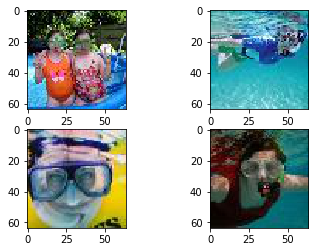

class  117


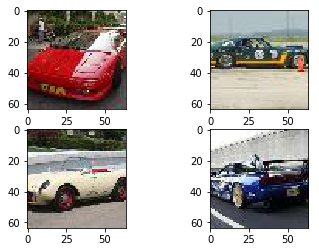

class  130


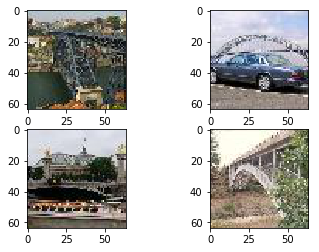

class  35


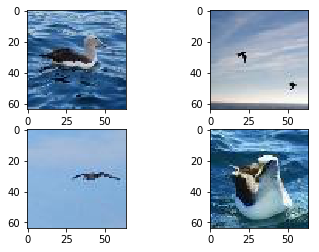

0

In [160]:
look_up_same_classes(X_train, y_train)

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [5]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [42]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 64 * 64, 1064))
model.add_module('dense2', nn.Linear(1064, 512))
model.add_module('dropout0', nn.Dropout(0.05)) 
model.add_module('dense3', nn.Linear(512, 256))
model.add_module('dropout1', nn.Dropout(0.05))
model.add_module('dense4', nn.Linear(256, 64))
model.add_module('dropout2', nn.Dropout(0.05))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 200)) # logits for 200 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [6]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model.cuda()(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [8]:
# example
compute_loss(X_train[:5], y_train[:5])

NameError: name 'model' is not defined

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [9]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [87]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [49]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.cpu().max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 11.569s
  training loss (in-iteration): 	5.296179
  validation accuracy: 			1.05 %
Epoch 2 of 100 took 11.052s
  training loss (in-iteration): 	5.251684
  validation accuracy: 			1.18 %
Epoch 3 of 100 took 10.906s
  training loss (in-iteration): 	5.133673
  validation accuracy: 			1.96 %
Epoch 4 of 100 took 11.024s
  training loss (in-iteration): 	5.056474
  validation accuracy: 			2.94 %
Epoch 5 of 100 took 11.066s
  training loss (in-iteration): 	4.976044
  validation accuracy: 			3.48 %
Epoch 6 of 100 took 11.089s
  training loss (in-iteration): 	4.897729
  validation accuracy: 			4.15 %
Epoch 7 of 100 took 11.072s
  training loss (in-iteration): 	4.846910
  validation accuracy: 			4.53 %
Epoch 8 of 100 took 10.880s
  training loss (in-iteration): 	4.810978
  validation accuracy: 			4.33 %
Epoch 9 of 100 took 10.984s
  training loss (in-iteration): 	4.779569
  validation accuracy: 			5.18 %


KeyboardInterrupt: 

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [11]:
print (6)

6


In [71]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.cpu().max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 70:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 20:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 15:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		6.76 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 4x4 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=100, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

__HACK_OF_THE_DAY__ :the number of channels must be in the order of the number of class_labels

In [79]:
model = nn.Sequential()

# reshape from "images" to flat vectors
#model.add_module('flatten', Flatten())

# dense "head"
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=100, kernel_size=4, stride=2, padding=1)) # convolution
model.add_module('conv_relu', nn.ReLU()) # convolution
model.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2)) # max pooling 2x2

model.add_module('conv2', nn.Conv2d(in_channels=100, out_channels=100, kernel_size=4, stride=1, padding=0)) # convolution
model.add_module('conv_relu2', nn.ReLU()) # convolution
model.add_module('pool2', nn.MaxPool2d(kernel_size=2, stride=2)) # max pooling 2x2

model.add_module('flatten', Flatten())
model.add_module('dense1', nn.Linear(3600, 1024))
model.add_module('dropout', nn.Dropout(0.4)) 
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense1_logits', nn.Linear(1024, 200)) # logits for 200 classes

In [80]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [86]:
from torchsummary import summary

summary(model.cuda(), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 150, 32, 32]           7,350
       BatchNorm2d-2          [-1, 150, 32, 32]             300
              ReLU-3          [-1, 150, 32, 32]               0
         MaxPool2d-4          [-1, 150, 16, 16]               0
            Conv2d-5          [-1, 160, 13, 13]         384,160
       BatchNorm2d-6          [-1, 160, 13, 13]             320
              ReLU-7          [-1, 160, 13, 13]               0
         MaxPool2d-8            [-1, 160, 6, 6]               0
           Flatten-9                 [-1, 5760]               0
           Linear-10                 [-1, 1024]       5,899,264
          Dropout-11                 [-1, 1024]               0
             ReLU-12                 [-1, 1024]               0
           Linear-13                  [-1, 200]         205,000
Total params: 6,496,394
Trainable param

## retrain it ##

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [161]:
## let's train the net ##

```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 20% validation accuracy at peak.

To learn more about **batch_norm** and **data covariate shift** go to

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c  (note)

https://www.youtube.com/watch?v=nUUqwaxLnWs (vidio)

In [170]:
model = nn.Sequential()

# reshape from "images" to flat vectors
#model.add_module('flatten', Flatten())

# dense "head"
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=150, kernel_size=4, stride=2, padding=1)) # convolution
model.add_module('bn1', nn.BatchNorm2d(150))
model.add_module('conv_relu', nn.ReLU()) # convolution
model.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2)) # max pooling 2x2

model.add_module('conv2', nn.Conv2d(in_channels=150, out_channels=160, kernel_size=4, stride=1, padding=0)) # convolution
model.add_module('bn2', nn.BatchNorm2d(160))
model.add_module('conv_relu2', nn.ReLU()) # convolution
model.add_module('pool2', nn.MaxPool2d(kernel_size=2, stride=2)) # max pooling 2x2


model.add_module('flatten', Flatten())
model.add_module('dense1', nn.Linear(5760, 1024))
model.add_module('batchnorm_dense', nn.BatchNorm1d(1024))
model.add_module('dropout', nn.Dropout(0.4)) 
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense1_logits', nn.Linear(1024, 200)) # logits for 200 classes

In [171]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [134]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration


for epoch in range(num_epochs):
    print (num_epochs)
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
    print (num_epochs)    
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.cpu().max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    print (num_epochs)
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

100
100
100
Epoch 1 of 100 took 98.468s
  training loss (in-iteration): 	5.000064
  validation accuracy: 			3.95 %
100
100
100
Epoch 2 of 100 took 98.234s
  training loss (in-iteration): 	4.637359
  validation accuracy: 			8.64 %
100
100
100
Epoch 3 of 100 took 98.098s
  training loss (in-iteration): 	4.438909
  validation accuracy: 			9.27 %
100
100
100
Epoch 4 of 100 took 98.368s
  training loss (in-iteration): 	4.286053
  validation accuracy: 			10.41 %
100
100
100
Epoch 5 of 100 took 98.280s
  training loss (in-iteration): 	4.166742
  validation accuracy: 			10.72 %
100
100
100
Epoch 6 of 100 took 98.260s
  training loss (in-iteration): 	4.057210
  validation accuracy: 			12.63 %
100
100
100
Epoch 7 of 100 took 98.146s
  training loss (in-iteration): 	3.954752
  validation accuracy: 			12.71 %
100
100
100
Epoch 8 of 100 took 98.115s
  training loss (in-iteration): 	3.864523
  validation accuracy: 			14.87 %
100
100
100
Epoch 9 of 100 took 100.780s
  training loss (in-iteration): 	3

KeyboardInterrupt: 


```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

When testing, we don't need random crops, just normalize with same statistics.

In [175]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    #transforms.RandomRotation([-15, 15]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [176]:
import torchvision

In [177]:
dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transform_augment)

In [178]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [90000, 10000])

In [179]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

In [180]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

In [181]:
from torchsummary import summary

summary(model.cuda(), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 150, 32, 32]           7,350
       BatchNorm2d-2          [-1, 150, 32, 32]             300
              ReLU-3          [-1, 150, 32, 32]               0
         MaxPool2d-4          [-1, 150, 16, 16]               0
            Conv2d-5          [-1, 160, 13, 13]         384,160
       BatchNorm2d-6          [-1, 160, 13, 13]             320
              ReLU-7          [-1, 160, 13, 13]               0
         MaxPool2d-8            [-1, 160, 6, 6]               0
           Flatten-9                 [-1, 5760]               0
           Linear-10                 [-1, 1024]       5,899,264
      BatchNorm1d-11                 [-1, 1024]           2,048
          Dropout-12                 [-1, 1024]               0
             ReLU-13                 [-1, 1024]               0
           Linear-14                  [

In [184]:
print (6)

6


In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 50 # total amount of full passes over training data
import time 

for epoch in range(num_epochs):
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    print (100)
    for (X_batch, y_batch) in train_batch_gen:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
    print (100)
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    print (100)
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

100
100
100
Epoch 1 of 50 took 155.359s
  training loss (in-iteration): 	3.131473
  validation accuracy: 			30.35 %
100
100
100
Epoch 2 of 50 took 136.111s
  training loss (in-iteration): 	2.988809
  validation accuracy: 			32.03 %
100
100
100
Epoch 3 of 50 took 164.075s
  training loss (in-iteration): 	2.882978
  validation accuracy: 			33.03 %
100
100
100
Epoch 4 of 50 took 164.898s
  training loss (in-iteration): 	2.776288
  validation accuracy: 			34.25 %
100
100
100
Epoch 5 of 50 took 155.720s
  training loss (in-iteration): 	2.682995
  validation accuracy: 			35.10 %
100
100
100
Epoch 6 of 50 took 134.035s
  training loss (in-iteration): 	2.602971
  validation accuracy: 			35.81 %
100
100
100
Epoch 7 of 50 took 163.443s
  training loss (in-iteration): 	2.538140
  validation accuracy: 			36.35 %
100
100
100
Epoch 8 of 50 took 134.434s
  training loss (in-iteration): 	2.461313
  validation accuracy: 			37.29 %
100
100
100
Epoch 9 of 50 took 162.125s
  training loss (in-iteration): 

We need for test data __only normalization__, not cropping and rotation

In [111]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/val', transform=transform_test)

SyntaxError: invalid syntax (<ipython-input-111-89f8cabd8df5>, line 6)

## The Quest For A Better Network

See `practical_dl/homework02` for a full-scale assignment.